In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

データの準備。
1. Ageの穴埋め
1. Embarkedの穴埋め
1. Ageを10歳刻みにする
1. Embarkedの水準ごとのAgeRankの人数を数える

In [2]:
df = pd.read_csv("titanic/train.csv")
df.loc[df.Age.isnull(), "Age"] = np.mean(df.Age)
df.loc[df.Embarked.isnull(), "Embarked"] = "S"
df["AgeRank"] = (df.Age // 10).apply(int)
df2 = df.groupby(["Embarked", "AgeRank"]).size().reset_index(name="count")
df2

,Embarked,AgeRank,count
0,C,0,9
1,C,1,20
2,C,2,76
3,C,3,28
4,C,4,17
5,C,5,13
6,C,6,3
7,C,7,2
8,Q,0,4
9,Q,1,6


縦持ち・横持ち変換して、NaNを0で埋める

In [3]:
df3 = df2.pivot(index="Embarked", columns="AgeRank", values="count").fillna(0)
df3

AgeRank,0,1,2,3,4,5,6,7,8
Embarked,,,,,,,,,
C,9.0,20.0,76.0,28.0,17.0,13.0,3.0,2.0,0.0
Q,4.0,6.0,54.0,7.0,3.0,1.0,1.0,1.0,0.0
S,49.0,76.0,267.0,132.0,69.0,34.0,15.0,3.0,1.0


グラフを書く
cf. https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html

<BarContainer object of 3 artists>

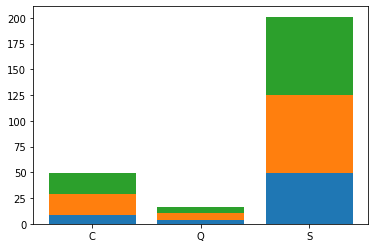

In [4]:
plt.bar(df3.index, df3.loc[:,0])
plt.bar(df3.index, df3.loc[:,1], bottom=df3.loc[:,0])
plt.bar(df3.index, df3.loc[:,1], bottom=df3.loc[:,0]+df3.loc[:,1])

原理的には、上でできることが分かった。
bottom引数に与えるために、各行の累積和が必要。

In [5]:
df4 = np.cumsum(df3, axis=1)
df4

AgeRank,0,1,2,3,4,5,6,7,8
Embarked,,,,,,,,,
C,9.0,29.0,105.0,133.0,150.0,163.0,166.0,168.0,168.0
Q,4.0,10.0,64.0,71.0,74.0,75.0,76.0,77.0,77.0
S,49.0,125.0,392.0,524.0,593.0,627.0,642.0,645.0,646.0


df4の中身を、1列右に移動させる

In [22]:
zeros = pd.Series(np.zeros(len(df4)), index=df4.index)
df5 = pd.concat([temp1, df4], axis=1).iloc[:,:-1]
df5.columns = df4.columns
df5

AgeRank,0,1,2,3,4,5,6,7,8
Embarked,,,,,,,,,
C,0.0,9.0,29.0,105.0,133.0,150.0,163.0,166.0,168.0
Q,0.0,4.0,10.0,64.0,71.0,74.0,75.0,76.0,77.0
S,0.0,49.0,125.0,392.0,524.0,593.0,627.0,642.0,645.0


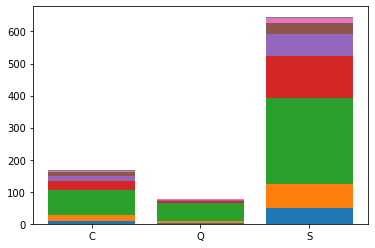

In [7]:
for i in df3.columns:
    plt.bar(df3.index, df3.loc[:,i], bottom=df5.loc[:,i])

とりあえず、図にはできた。凡例はfuture workとする。次は、割合で積み上げグラフを書く

行ごとに、各要素の行内での割合を計算

In [18]:
sums = df3.apply(sum, axis=1)
df6 = df3.copy()
for i in range(len(df3)):
    df6.iloc[i,:] = df3.iloc[i,:] / sums[i] * 100
df6    

AgeRank,0,1,2,3,4,5,6,7,8
Embarked,,,,,,,,,
C,5.357143,11.904762,45.238095,16.666667,10.119048,7.738095,1.785714,1.190476,0.000000
Q,5.194805,7.792208,70.129870,9.090909,3.896104,1.298701,1.298701,1.298701,0.000000
S,7.585139,11.764706,41.331269,20.433437,10.681115,5.263158,2.321981,0.464396,0.154799


割合の累積和を計算

In [23]:
df7 = np.cumsum(df6, axis=1)
df7

AgeRank,0,1,2,3,4,5,6,7,8
Embarked,,,,,,,,,
C,5.357143,17.261905,62.500000,79.166667,89.285714,97.023810,98.809524,100.000000,100.0
Q,5.194805,12.987013,83.116883,92.207792,96.103896,97.402597,98.701299,100.000000,100.0
S,7.585139,19.349845,60.681115,81.114551,91.795666,97.058824,99.380805,99.845201,100.0


累積和を一列右にずらして、左に0の列を追加

In [37]:
zeros2 = pd.Series(np.zeros(len(df7)), index=df7.index)
df8 = pd.concat([zeros2, df7], axis=1).iloc[:,:-1]
df8.columns = df7.columns
df8

AgeRank,0,1,2,3,4,5,6,7,8
Embarked,,,,,,,,,
C,0.0,5.357143,17.261905,62.500000,79.166667,89.285714,97.023810,98.809524,100.000000
Q,0.0,5.194805,12.987013,83.116883,92.207792,96.103896,97.402597,98.701299,100.000000
S,0.0,7.585139,19.349845,60.681115,81.114551,91.795666,97.058824,99.380805,99.845201


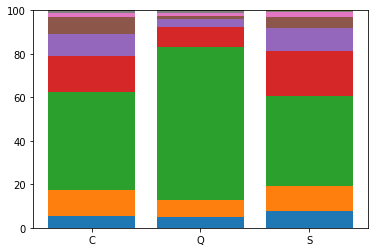

In [38]:
for i in df6.columns:
    plt.bar(df6.index, df6.loc[:,i], bottom=df8.loc[:,i])